<a href="https://colab.research.google.com/github/CodingTomo/PyTorch-Tutorials/blob/master/PyTorch_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
if not os.path.exists('PyTorch-Tutorials'):
  !git clone https://github.com/CodingTomo/PyTorch-Tutorials #clono la repository

### Autoencoders

Un **autoencoder** è una particolare rete neurale usata per *representation learning*. Si costruisce una rete neurale prevedendo di comprimere la rappresentazione iniziale degli input. L'idea è poi quella di addestrare la rete a ricostruire il dato di partenza dal dato compresso.

Questa è un'idea usata per la prima volta nell'analisi delle **componenti principali** (PCA). La PCA è infatti uno dei principali e più usati metodi di *representation learning* ed è basato su un sapiente uso dell'algebra lineare. Proprio l'uso dell'algebra lineare lo rende un metodo estremamente solido dal punto di teorico ed efficiente, ma spesso non troppo efficace in contesti reali. Il motivo è che il metodo cerca di comprimere la rappresentazione appunto in termini lineari cercando un iperpiano di dimensionalità ridotta rispetto ai dati che meglio approssima i dati stessi. Gli autoencoders possono superare il limite della linearità diventando di fatto una generalizzazione della PCA.

<p><center>
<img src=https://github.com/CodingTomo/PyTorch-Tutorials/blob/master/Immagini/ae-pca.png?raw=1 width="400" style="margin-left: auto;margin-right: auto;display: block;" />
</center></p>

Image:[Jeremy Jordan](https://www.jeremyjordan.me)

Un esempio giocattolo di **architettura** di un autoencoder è la seguente.

<p><center>
<img src=https://github.com/CodingTomo/PyTorch-Tutorials/blob/master/Immagini/ae.png?raw=1 width="400" style="margin-left: auto;margin-right: auto;display: block;" />
</center></p>

Per capire il funzionamento e la corretta implementazione di un **autoencoder** useremo ancora il dataset MNIST.

In [2]:
import torchvision
import torch
import torch.nn as nn
from torchvision.utils import make_grid

import numpy as np
from typing import List, Tuple

import matplotlib.pyplot as plt

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False, # specifica che ci serve la parte di test
    transform=torchvision.transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, pin_memory=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False,  pin_memory=False)

print('Il numero di minibatch generati per il train è {}, mentre per il test è {}'.format(len(train_loader),len(test_loader)))

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Il numero di minibatch generati per il train è 469, mentre per il test è 79


Apriamo una piccola parentesi per quanto riguarda l'**inizializzazione** dei parametri di una rete neurale. Questa operazione, per quanto possa sembrare innoqua, è di importanza fondamentale e concorre a determinare la bontà del nostro addestramento. L'idea è che più è profonda la rete neurale più sono necessari prodotti fra matrici per arrivare da cima a fondo e viceversa. Se inizialemente gli elementi delle matrici sono troppo grandi o troppo piccoli allora gli innumerevoli prodotti tenderanno a far esplodere o svanire i parametri della rete rendendo impossibile sostenere lunghe sessioni di training. 

Nel nostro caso scegliamo di inizializzare i parametri con la tecnica **Kaiming** adatta alle situazioni in cui le non-linerità della rete sono ReLU.

In [0]:
def init_weights(my_module):
      for sub_module in my_module.modules():
        if isinstance(sub_module, nn.Linear): #controlla se è m è un offetto di tipo nn.Linear
            nn.init.kaiming_normal_(sub_module.weight, nonlinearity='relu')
            nn.init.constant_(sub_module.bias, 0)

L'**encoder** è la prima delle due parti della nostra rete neurale. Si prende carico di leggere i dati di input e ridurli di dimensione in maniera progressiva. Osserviamo che il dato in uscita dall'encoder rappresenta l'**embedding** dei dati nello spazio ridotto.

Nel nostro caso eseguiamo le seguenti operazioni:


1.   riduciamo la matrice a vettore;
2.   applichiamo una regressione lineare portando la dimesionalità da 784 a 512;
3.   applichiamo la ReLU;
4.   applichiamo una regressione lineare portando la dimensionalità da 512 a 256.



In [0]:
class Encoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.encoder = nn.Sequential(nn.Flatten(),
                                 nn.Linear(np.prod(inp_shape), hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, out_dim))
        init_weights(self)

    def forward(self, x): 
        return self.encoder(x)

In [5]:
en=Encoder(inp_shape=(28, 28), hidden_dim=512, out_dim=256)
print("L'architettura dell'encoder è: \n", en)

L'architettura dell'encoder è: 
 Encoder(
  (encoder): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
  )
)


Il **decoder** prende in input l'embedding del dato in uscita dall'encoder e cerca di ricostruire la struttura originale.

Nel nostro caso eseguiamo le seguenti operazioni:
   
1.   applichiamo una regressione lineare portando la dimesionalità da 256 a 512;
2.   applichiamo la ReLU;
3.   applichiamo una regressione lineare portando la dimensionalità da 512 a 784.


In [0]:
class Decoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.inp_shape = inp_shape
        
        self.decoder = nn.Sequential(nn.Linear(out_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, np.prod(inp_shape)))  
        init_weights(self)
        
    def forward(self, x): 
        return torch.sigmoid(self.decoder(x)).view(x.shape[0], *self.inp_shape)

In [7]:
de=Decoder(inp_shape=(28, 28), hidden_dim=512, out_dim=256)
print("L'architettura dell'decoder è: \n", de)

L'architettura dell'decoder è: 
 Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
  )
)


Fondendo le due architetture si ottiene l'**autoencoder** completo.

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.ae = nn.Sequential(Encoder(inp_shape, hidden_dim, out_dim),
                                Decoder(inp_shape, hidden_dim, out_dim))
        
    def forward(self, x): 
        return self.ae(x)

In [9]:
autoencoder = AutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256)
autoencoder

AutoEncoder(
  (ae): Sequential(
    (0): Encoder(
      (encoder): Sequential(
        (0): Flatten()
        (1): Linear(in_features=784, out_features=512, bias=True)
        (2): ReLU()
        (3): Linear(in_features=512, out_features=256, bias=True)
      )
    )
    (1): Decoder(
      (decoder): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
  )
)

Definiamo un funzione che ci aiuterà a capire i **progressi** in termini di ricostruzione dell'immagine durante l'addestramento dell'autoencoder.

Analizziamo la seguente riga di codice:

```
iterator = enumerate(test_loader)
```

La funzione `enumerate()` restituisce un iteratore che può essere fatto scorrere sul *test_loader* tramite la funzione `next()` o tramite un ciclo. Teniamo a mente che 

```
type(next(iterator)) = tuple
```
In particolare, `type(next(iterator))[0] = int` e `type(next(iterator))[0] = list`.





In [0]:
def Summary(valid_dl, model: nn.Module):

    sample = 10
    model.eval() 
    actuals, preds = [], []
    
    with torch.no_grad():
        for i,(x, y) in enumerate(valid_dl.dataset):
            actuals.append(x)
            recon_x = model(x.unsqueeze(0).cuda()).cpu() # la funzione unsqueeze() adatta le dimensione dell'immagine x per il modello!
            preds.append(recon_x.squeeze(0)) 
            if i + 1 == sample:
                break
                
    model.train()

    grid = make_grid([*actuals, *preds], pad_value=1, padding=1, nrow=sample)

    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

Definiamo il ciclo di **train**.

In [0]:
 def train_ae(train_dl, 
             valid_dl,
             model: nn.Module,
             n_epochs: int):
    
    log_interval = 10
    summary_interval = 10
    
    model = model.cuda()
    
    loss_function = nn.MSELoss(reduction='mean') #L2 loss
    optim = torch.optim.Adam(model.parameters())
    
    acc_loss = 0
    
    print("Capacità ricostruttive prima dell'addestramento.")
    Summary(valid_dl, model)

    for epoch in range(n_epochs):
        i = 1

        for x, _ in train_dl: # le etichette non servono mai
            optim.zero_grad()    
            x = x.cuda()
            x_recon = model(x)
            loss = loss_function(x, x_recon) 
            acc_loss += loss.item()
            loss.backward() 
            optim.step()
            
            if (i + 1) % log_interval == 0 and epoch == 0 and i<201:
                print("Epoca {} - iterazione {}. \n L'errore in questa iterazione è stato: {}".format(epoch + 1, i + 1 ,acc_loss))
                acc_loss = 0
                
            if (i + 1) % summary_interval == 0 and epoch == 0 and i<201:
                Summary(valid_dl, model)

            acc_loss = 0    
            i += 1
          
        print("... sono al {:.0%} dell'addestramento".format((epoch+1)/n_epochs))

    print("Capacità ricostruttive a fine addestramento.")
    Summary(valid_dl, model)
    print("Errore a fine addestramento è stato {:.50f}".format(acc_loss))

**Addestriamo** il modello!

In [0]:
train_ae(train_loader, test_loader, autoencoder, 20)

**Esercizio**: la funzione di addestremento e quella di monitoraggio iterano in maniera diversa sui i rispettivi *dataloader*. Perchè?

Giustifichiamo adesso il paragone con PCA e andiamo a esplorare lo spazio **latente**. Per ragioni di visualizzazione lo ridurremo fino ad avere dimensione 2.

In [0]:
ae_lat = AutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=2)


Se abbiamo voglia di un caffè, addestriamo il modello da capo, altrimenti **carichiamo** i parametri dalla repository e guardiamo i risultati.

In [0]:
caffe=1

if caffe==0:
  train_ae(train_loader, test_loader, ae_lat, 80)
else:
  ae_lat.load_state_dict(torch.load("/content/PyTorch-Tutorials/Modelli/ae_lat_80.dms"))

Una volta addestrato il nuovo autoencoder, consideriamo l'insieme di test ed eseguiamo la sola fase di **encoding** utilizzando il comando


```
ae_lat.ae[0](x)
```



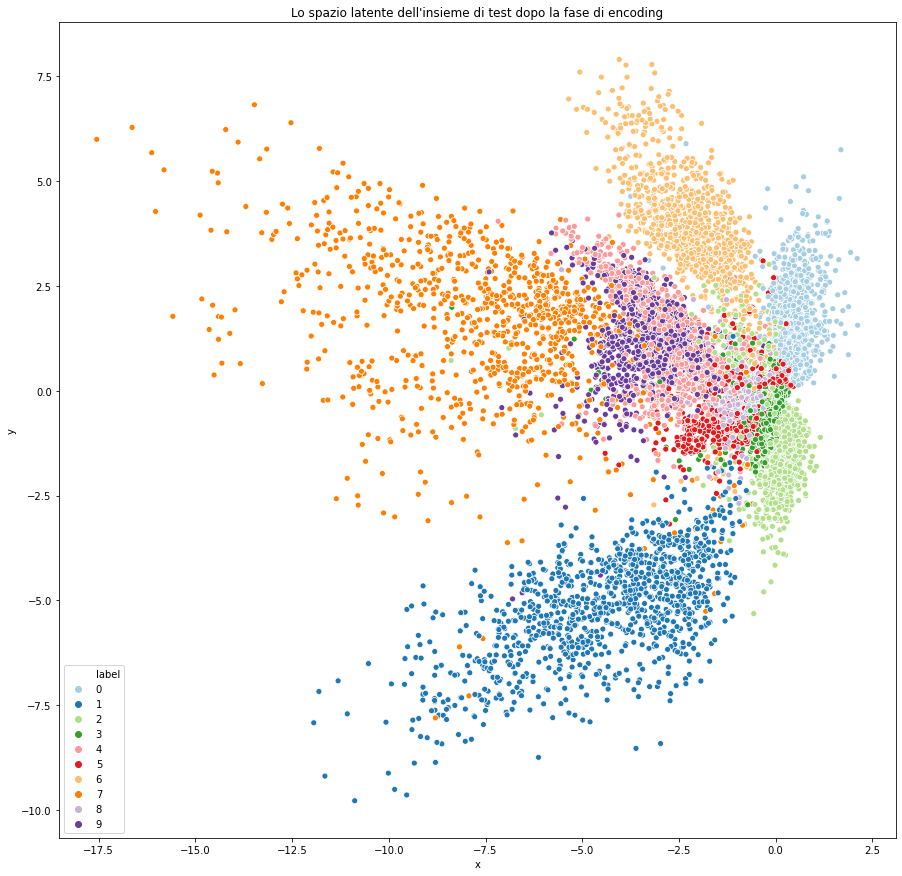

In [22]:
import pandas as pd
import seaborn as sns

z, labels = [], []
for i, (x, y) in enumerate(test_loader):
    ae_lat = ae_lat.cuda()
    enc = ae_lat.ae[0](x.cuda()).detach() 
    enc = enc.cpu()
    z.append(enc)
    labels.append(y)
z = torch.cat(z, dim=0)
labels = torch.cat(labels, dim=0)

df = pd.DataFrame({'x': z[:,0].numpy(), 
                   'y': z[:,1].numpy(),
                   'label': labels.numpy()})

plt.figure(figsize=(15, 15))
sns.scatterplot(x="x", y="y", hue="label", palette=sns.color_palette("Paired", 10), data=df, legend="full")
plt.title("Lo spazio latente dell'insieme di test dopo la fase di encoding");